## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp001'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 32 # 16
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 15 # 30

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

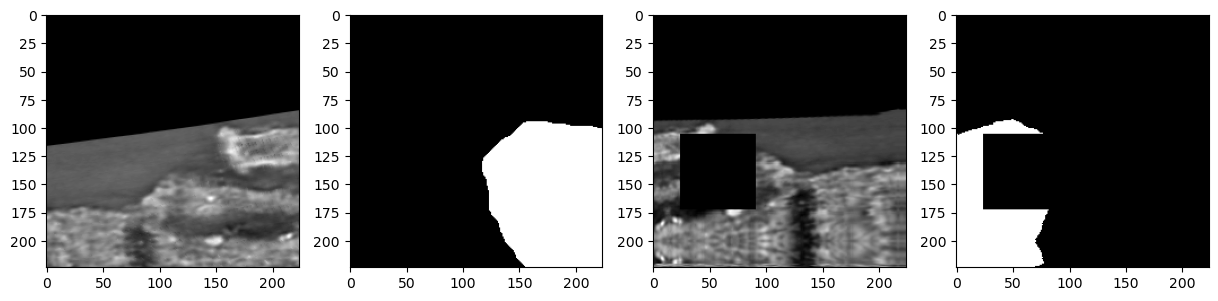

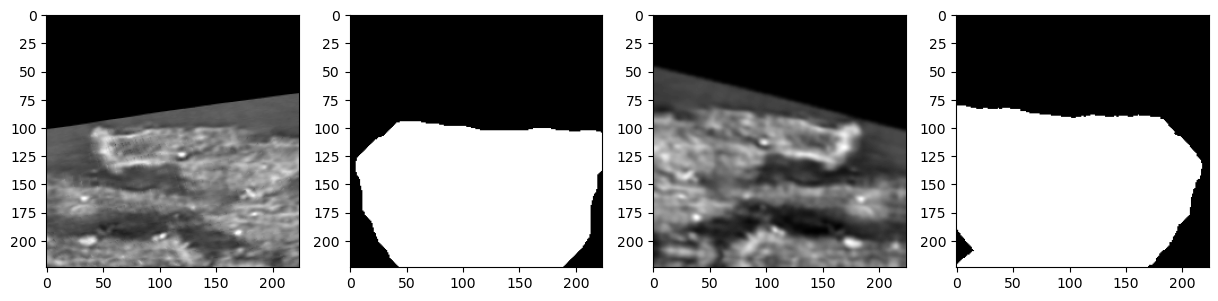

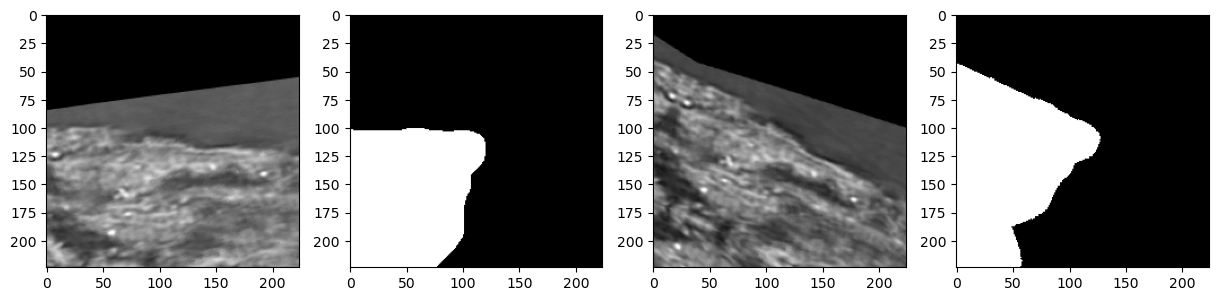

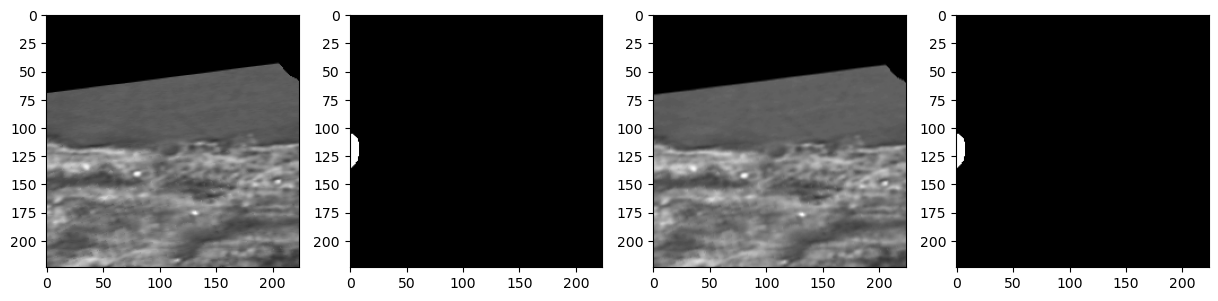

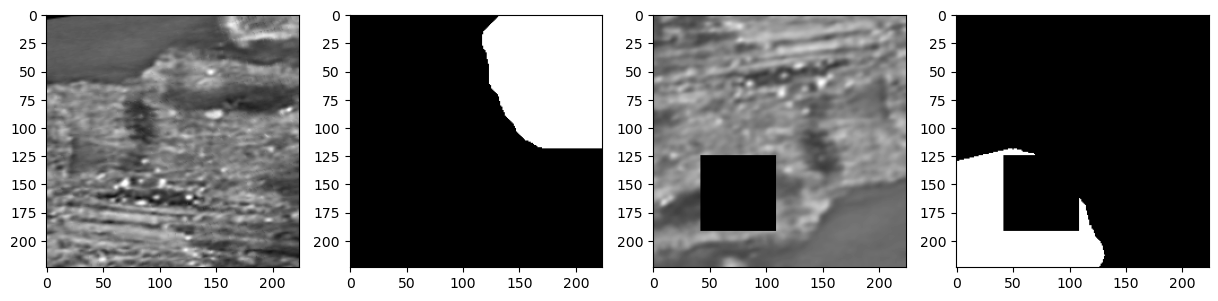

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48110

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501385954981358
th: 0.15, fbeta: 0.09501895674278188
th: 0.2, fbeta: 0.09515162142414017
th: 0.25, fbeta: 0.1441493612206351
th: 0.3, fbeta: 0.1841572127946994
th: 0.35, fbeta: 0.23509934966064974
th: 0.4, fbeta: 0.2899442583212825
th: 0.45, fbeta: 0.33518525337724797


best_th: 0.5, fbeta: 0.3618610135236908
Epoch 1 - avg_train_loss: 0.5999  avg_val_loss: 0.4221  time: 126s
Epoch 1 - avgScore: 0.3619
Epoch 1 - Save Best Score: 0.3619 Model
Epoch 1 - Save Best Loss: 0.4221 Model


th: 0.5, fbeta: 0.3618610135236908


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.0950138029922514
th: 0.15, fbeta: 0.09502374566814537
th: 0.2, fbeta: 0.14330207061921563
th: 0.25, fbeta: 0.1775952212002729
th: 0.3, fbeta: 0.25711155102156164
th: 0.35, fbeta: 0.3310389226461848
th: 0.4, fbeta: 0.38383835513560965
th: 0.45, fbeta: 0.42263963869008647


best_th: 0.5, fbeta: 0.4460985378531676
Epoch 2 - avg_train_loss: 0.4275  avg_val_loss: 0.3656  time: 127s
Epoch 2 - avgScore: 0.4461
Epoch 2 - Save Best Score: 0.4461 Model
Epoch 2 - Save Best Loss: 0.3656 Model


th: 0.5, fbeta: 0.4460985378531676


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.22833382006093877
th: 0.15, fbeta: 0.2967167442709055
th: 0.2, fbeta: 0.3482725172492075
th: 0.25, fbeta: 0.3902181891862306
th: 0.3, fbeta: 0.42970262257613345
th: 0.35, fbeta: 0.46882292465766423
th: 0.4, fbeta: 0.5017233368637192
th: 0.45, fbeta: 0.5265366142396865


best_th: 0.5, fbeta: 0.537229023305902
Epoch 3 - avg_train_loss: 0.3115  avg_val_loss: 0.2137  time: 127s
Epoch 3 - avgScore: 0.5372
Epoch 3 - Save Best Score: 0.5372 Model
Epoch 3 - Save Best Loss: 0.2137 Model


th: 0.5, fbeta: 0.537229023305902


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.18390939818072724
th: 0.15, fbeta: 0.20320134406657586
th: 0.2, fbeta: 0.22032957241075252
th: 0.25, fbeta: 0.23506617708526228
th: 0.3, fbeta: 0.24981882366847413
th: 0.35, fbeta: 0.2658170982378838
th: 0.4, fbeta: 0.28398926792403273
th: 0.45, fbeta: 0.3030457310440753


best_th: 0.5, fbeta: 0.3241408357677701
Epoch 4 - avg_train_loss: 0.2447  avg_val_loss: 0.3234  time: 127s
Epoch 4 - avgScore: 0.3241


th: 0.5, fbeta: 0.3241408357677701


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2389146049952971
th: 0.15, fbeta: 0.28025455736032495
th: 0.2, fbeta: 0.3176874272909987
th: 0.25, fbeta: 0.3530335149071521
th: 0.3, fbeta: 0.39129790247429314
th: 0.35, fbeta: 0.43264464561201327
th: 0.4, fbeta: 0.4764740504446531
th: 0.45, fbeta: 0.522864872021255


best_th: 0.5, fbeta: 0.5665736036520725
Epoch 5 - avg_train_loss: 0.2210  avg_val_loss: 0.2027  time: 127s
Epoch 5 - avgScore: 0.5666
Epoch 5 - Save Best Score: 0.5666 Model
Epoch 5 - Save Best Loss: 0.2027 Model


th: 0.5, fbeta: 0.5665736036520725


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.19977519115146006
th: 0.15, fbeta: 0.2304523303919207
th: 0.2, fbeta: 0.2616760821139178
th: 0.25, fbeta: 0.2982697122112115
th: 0.3, fbeta: 0.3384069944146571
th: 0.35, fbeta: 0.3810959533205782
th: 0.4, fbeta: 0.4221253405990413
th: 0.45, fbeta: 0.4602617994630044


best_th: 0.5, fbeta: 0.49537614945720393
Epoch 6 - avg_train_loss: 0.2061  avg_val_loss: 0.2346  time: 127s
Epoch 6 - avgScore: 0.4954


th: 0.5, fbeta: 0.49537614945720393


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2162904606365105
th: 0.15, fbeta: 0.23763971616314403
th: 0.2, fbeta: 0.26141347323258646
th: 0.25, fbeta: 0.28742662045651185
th: 0.3, fbeta: 0.3153077265546549
th: 0.35, fbeta: 0.3421741457722429
th: 0.4, fbeta: 0.36974845419033275
th: 0.45, fbeta: 0.3982294767501975


best_th: 0.5, fbeta: 0.4313789187271402
Epoch 7 - avg_train_loss: 0.1909  avg_val_loss: 0.2572  time: 127s
Epoch 7 - avgScore: 0.4314


th: 0.5, fbeta: 0.4313789187271402


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.27144400153096576
th: 0.15, fbeta: 0.30838607820389413
th: 0.2, fbeta: 0.3424027763015693
th: 0.25, fbeta: 0.374501312937461
th: 0.3, fbeta: 0.4043252467902816
th: 0.35, fbeta: 0.435341241022758
th: 0.4, fbeta: 0.46364762394738374
th: 0.45, fbeta: 0.4878192936099562


best_th: 0.5, fbeta: 0.5073120462339876
Epoch 8 - avg_train_loss: 0.1776  avg_val_loss: 0.2137  time: 128s
Epoch 8 - avgScore: 0.5073


th: 0.5, fbeta: 0.5073120462339876


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2289268765053658
th: 0.15, fbeta: 0.25347736213722244
th: 0.2, fbeta: 0.2783610343556113
th: 0.25, fbeta: 0.3049029156091017
th: 0.3, fbeta: 0.3324693884162601
th: 0.35, fbeta: 0.3656994259880525
th: 0.4, fbeta: 0.40178711284153856
th: 0.45, fbeta: 0.43847298980786825


best_th: 0.5, fbeta: 0.4755666495636249
Epoch 9 - avg_train_loss: 0.1647  avg_val_loss: 0.2373  time: 127s
Epoch 9 - avgScore: 0.4756


th: 0.5, fbeta: 0.4755666495636249


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.266697908390644
th: 0.15, fbeta: 0.2950525146653464
th: 0.2, fbeta: 0.3186854097074252
th: 0.25, fbeta: 0.34165001444641024
th: 0.3, fbeta: 0.36403408371493484
th: 0.35, fbeta: 0.38506747339199104
th: 0.4, fbeta: 0.40556769426256384
th: 0.45, fbeta: 0.42843064075572523


best_th: 0.5, fbeta: 0.4515344823092648
Epoch 10 - avg_train_loss: 0.1516  avg_val_loss: 0.2460  time: 127s
Epoch 10 - avgScore: 0.4515


th: 0.5, fbeta: 0.4515344823092648


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2583965784304587
th: 0.15, fbeta: 0.28794952417096914
th: 0.2, fbeta: 0.3132817454552689
th: 0.25, fbeta: 0.3352794262384813
th: 0.3, fbeta: 0.35772607855782457
th: 0.35, fbeta: 0.3794000074417557
th: 0.4, fbeta: 0.40038064105191673
th: 0.45, fbeta: 0.4188889021850759


best_th: 0.5, fbeta: 0.43569054336990604
Epoch 11 - avg_train_loss: 0.1405  avg_val_loss: 0.2594  time: 127s
Epoch 11 - avgScore: 0.4357


th: 0.5, fbeta: 0.43569054336990604


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.26780409860923293
th: 0.15, fbeta: 0.3005015983318479
th: 0.2, fbeta: 0.32953674018483925
th: 0.25, fbeta: 0.35505087937879953
th: 0.3, fbeta: 0.3796166531082012
th: 0.35, fbeta: 0.40367418769475666
th: 0.4, fbeta: 0.42930482114197316
th: 0.45, fbeta: 0.4526758000171063


best_th: 0.5, fbeta: 0.475633162254307
Epoch 12 - avg_train_loss: 0.1313  avg_val_loss: 0.2266  time: 127s
Epoch 12 - avgScore: 0.4756


th: 0.5, fbeta: 0.475633162254307


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2933579614385885
th: 0.15, fbeta: 0.33242279478497627
th: 0.2, fbeta: 0.36485128519057947
th: 0.25, fbeta: 0.39472712754360206
th: 0.3, fbeta: 0.4225003420211852
th: 0.35, fbeta: 0.4497645588819967
th: 0.4, fbeta: 0.4745566344636159


best_th: 0.5, fbeta: 0.5184234544227267
Epoch 13 - avg_train_loss: 0.1236  avg_val_loss: 0.2223  time: 127s
Epoch 13 - avgScore: 0.5184


th: 0.45, fbeta: 0.49839724319878326
th: 0.5, fbeta: 0.5184234544227267


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.28789179281581495
th: 0.15, fbeta: 0.3194924728313189
th: 0.2, fbeta: 0.34615651913649137
th: 0.25, fbeta: 0.3707113189211551
th: 0.3, fbeta: 0.39327322340012727
th: 0.35, fbeta: 0.41560251927498476
th: 0.4, fbeta: 0.4362872849582361
th: 0.45, fbeta: 0.45802999730032184


best_th: 0.5, fbeta: 0.47775750661521943
Epoch 14 - avg_train_loss: 0.1171  avg_val_loss: 0.2418  time: 127s
Epoch 14 - avgScore: 0.4778


th: 0.5, fbeta: 0.47775750661521943


  0%|          | 0/483 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2942584992452127
th: 0.15, fbeta: 0.3271679136543887
th: 0.2, fbeta: 0.3558601353329751
th: 0.25, fbeta: 0.3824123447527161
th: 0.3, fbeta: 0.4077736487638738
th: 0.35, fbeta: 0.43215461673441097
th: 0.4, fbeta: 0.4560452112010094


best_th: 0.5, fbeta: 0.49910665648850183
Epoch 15 - avg_train_loss: 0.1127  avg_val_loss: 0.2324  time: 128s
Epoch 15 - avgScore: 0.4991


th: 0.45, fbeta: 0.4786833020501045
th: 0.5, fbeta: 0.49910665648850183


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.2389146049952971
th: 0.15, fbeta: 0.28025455736032495
th: 0.2, fbeta: 0.3176874272909987
th: 0.25, fbeta: 0.3530335149071521
th: 0.3, fbeta: 0.39129790247429314
th: 0.35, fbeta: 0.43264464561201327
th: 0.4, fbeta: 0.4764740504446531
th: 0.45, fbeta: 0.522864872021255


best_th: 0.5, fbeta: 0.5665736036520725


th: 0.5, fbeta: 0.5665736036520725


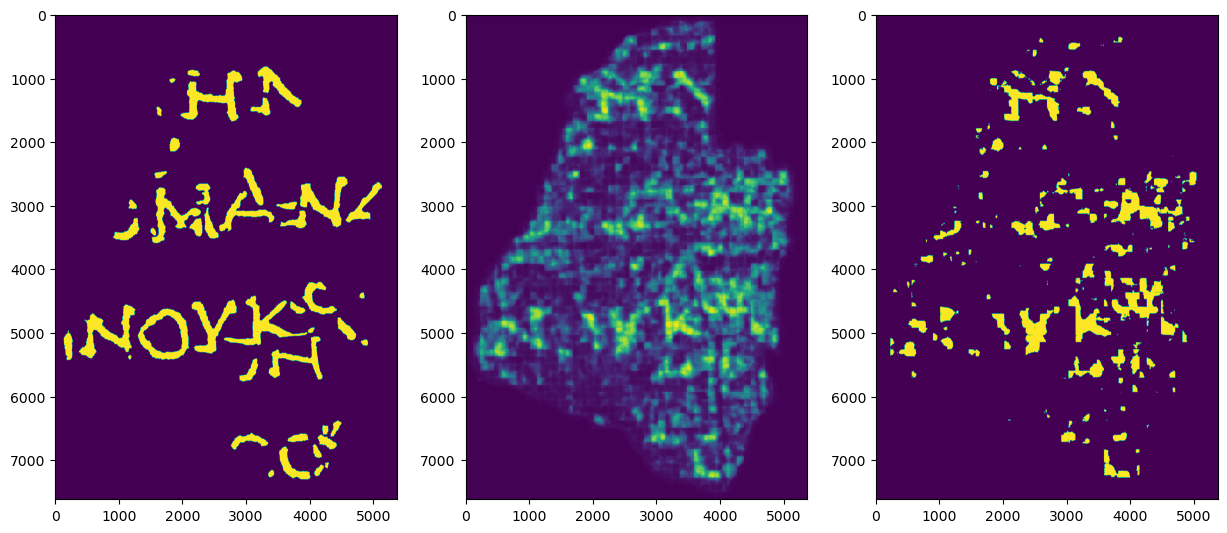

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([2.0579526e+07, 5.4936570e+06, 3.0355040e+06, 2.0758620e+06,
        1.5355650e+06, 1.2947850e+06, 1.1397600e+06, 9.8085700e+05,
        8.5335300e+05, 7.2355500e+05, 6.1860700e+05, 5.2430500e+05,
        4.5324600e+05, 4.0139300e+05, 3.7790700e+05, 3.2936900e+05,
        2.6533400e+05, 1.7787800e+05, 6.8476000e+04, 1.4677000e+04]),
 array([0.00095506, 0.04664725, 0.09233944, 0.13803163, 0.18372382,
        0.22941601, 0.2751082 , 0.32080039, 0.36649258, 0.41218477,
        0.45787696, 0.50356915, 0.54926134, 0.59495353, 0.64064572,
        0.68633791, 0.7320301 , 0.77772229, 0.82341448, 0.86910667,
        0.91479886]),
 <BarContainer object of 20 artists>)

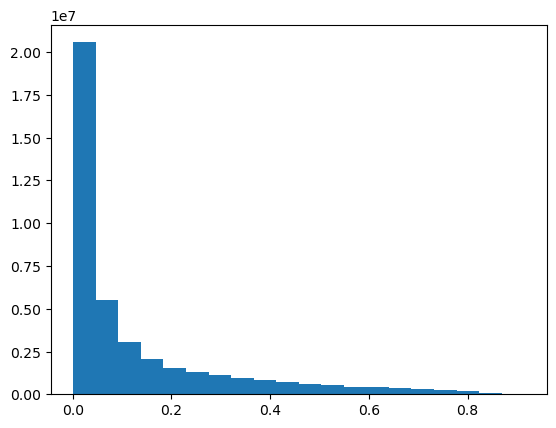

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000